In [1]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import os.path as op

In [3]:
client = boto3.resource('s3')
bucket_name = 'arokem.mri2mri'
b = client.Bucket(bucket_name)

In [4]:
txt_list = [ll.key for ll in list(b.objects.all())[1:] if (ll.key.startswith("IXI-data/multimodal_registration/") and ll.key.endswith('txt') and 'myunet' in ll.key)]

In [5]:
models = ["L1Only", "cgan_myunet/", "cgan_percept", "cgan_L1", "perceptOnly"]

In [6]:
dfs = []
for model in models: 
    RMS_trans_pred = []
    RMS_rot_pred = []
    RMS_trans_source = []
    RMS_rot_source = []
    subject = []
    err_list = [ll for ll in txt_list if ll.startswith("IXI-data/multimodal_registration/dti00_t1_%s"%model)]
    for efile in err_list:
        b.download_file(efile, 'err.txt')
        subject.append(op.split(efile)[-1].split('_')[1].split('-')[0])
        this_RMS_trans_pred, this_RMS_rot_pred, this_RMS_trans_source, this_RMS_rot_source = np.loadtxt('err.txt')
        RMS_trans_pred.append(this_RMS_trans_pred)
        RMS_rot_pred.append(this_RMS_rot_pred)
        RMS_trans_source.append(this_RMS_trans_source)
        RMS_rot_source.append(this_RMS_rot_source)
    dfs.append(pd.DataFrame(data={"RMS_trans_pred": RMS_trans_pred, 
                                  "RMS_rot_pred": RMS_rot_pred, 
                                  "RMS_trans_source": RMS_trans_source,
                                  "RMS_rot_source": RMS_rot_source, 
                                  "model": [model] * len(RMS_rot_source),
                                  "subject": subject}))

In [7]:
this_RMS_trans_source, this_RMS_trans_pred

(0.46163253, 2.00341041)

In [8]:
df = pd.concat(dfs)

In [9]:
from scipy import stats

L1Only
Rotation:
MannwhitneyuResult(statistic=1838.0, pvalue=4.133835164976934e-06)
Translation:
MannwhitneyuResult(statistic=2232.0, pvalue=0.0010075268373968766)
cgan_myunet/
Rotation:
MannwhitneyuResult(statistic=1803.0, pvalue=2.326607380533698e-06)
Translation:
MannwhitneyuResult(statistic=2167.0, pvalue=0.0004597901963222854)
cgan_percept
Rotation:
MannwhitneyuResult(statistic=1802.0, pvalue=2.288231172973265e-06)
Translation:
MannwhitneyuResult(statistic=2145.0, pvalue=0.0003487682894809276)
cgan_L1
Rotation:
MannwhitneyuResult(statistic=1813.0, pvalue=2.7458526293980697e-06)
Translation:
MannwhitneyuResult(statistic=2120.0, pvalue=0.00025307292063255204)
perceptOnly
Rotation:
MannwhitneyuResult(statistic=1899.0, pvalue=1.088072602708039e-05)
Translation:
MannwhitneyuResult(statistic=2118.0, pvalue=0.0002465862245411302)


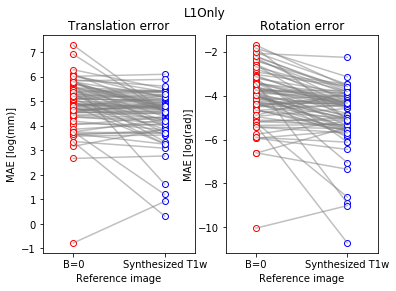

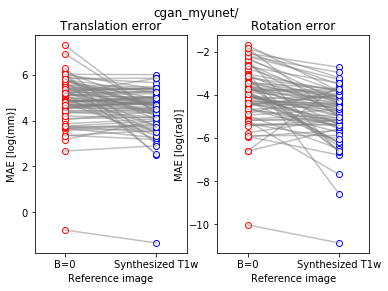

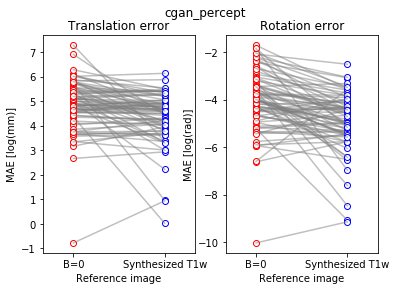

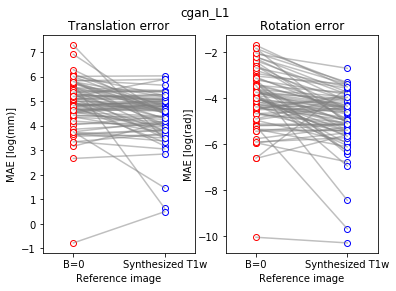

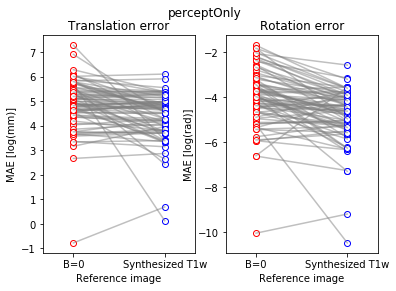

In [10]:
for model in models:
    this_df = df[df["model"] == model]
    fig, ax = plt.subplots(1, 2)
    fig.suptitle(model)
    for idx in range(this_df.shape[0]):
        row = this_df.iloc[idx]
        ax[0].plot(0.8, np.log(row['RMS_trans_pred']), 'ob', markerfacecolor='white')
        ax[0].plot(0.2, np.log(row['RMS_trans_source']), 'or', markerfacecolor='white')
        ax[0].plot([0.8, 0.2], [np.log(row['RMS_trans_pred']), 
                                np.log(row['RMS_trans_source'])], 
                                color='gray', alpha=0.5)
        ax[0].set_xlim([0, 1])
        ax[0].set_xticks([0.8, 0.2])
        ax[0].set_xticklabels(['Synthesized T1w','B=0'])
        ax[1].plot(0.8, np.log(row['RMS_rot_pred']), 'ob', markerfacecolor='white')
        ax[1].plot(0.2, np.log(row['RMS_rot_source']), 'or', markerfacecolor='white')
        ax[1].plot([0.8, 0.2], [np.log(row['RMS_rot_pred']),
                                np.log(row['RMS_rot_source'])],
                                color='gray', alpha=0.5)
        ax[1].set_xlim([0, 1])
        ax[1].set_xticks([0.8, 0.2])
        ax[1].set_xticklabels(['Synthesized T1w','B=0'])

    ax[0].set_title('Translation error')
    ax[0].set_ylabel('MAE [log(mm)]')
    ax[0].set_xlabel('Reference image')
    ax[1].set_title('Rotation error')
    ax[1].set_ylabel('MAE [log(rad)]')
    ax[1].set_xlabel('Reference image')
    print(model)
    print("Rotation:")
    print(stats.mannwhitneyu(np.log(this_df["RMS_rot_pred"]), np.log(this_df["RMS_rot_source"])))
    print("Translation:")
    print(stats.mannwhitneyu(np.log(this_df["RMS_trans_pred"]), np.log(this_df["RMS_trans_source"])))

In [11]:
import seaborn as sns

In [12]:
df[df["subject"] == "IXI012"]

,RMS_rot_pred,RMS_rot_source,RMS_trans_pred,RMS_trans_source,model,subject
0,0.008015,0.027429,61.215179,78.882543,L1Only,IXI012
0,0.010426,0.027429,64.714185,78.882543,cgan_myunet/,IXI012
0,0.000209,0.027429,1.028275,78.882543,cgan_percept,IXI012
0,0.006589,0.027429,41.303225,78.882543,cgan_L1,IXI012
0,0.008535,0.027429,60.898227,78.882543,perceptOnly,IXI012
